<a href="https://colab.research.google.com/github/Randoot/NLP-2/blob/main/Building_A_Transformer_From_Scratch_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Importing TensorFlow and Other Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

### 2. Defining Positional Encoding Class
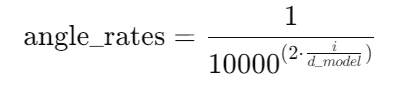

In [2]:
# Incorporate information about the positions of tokens in a sequence
class PositionalEncoding(layers.Layer):
  # d_model: The dimensionality of the model = the size of the token embeddings.
  #  max_len: The maximum length of the sequences for which positional encoding will be computed.

    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        #self.pos_encoding=  This is the positional encoding matrix
        # calculated using the positional_encoding method.
        self.pos_encoding = self.positional_encoding(max_len, d_model)
#calculate the angles used in the positional encoding formula
#pos: A vector of position indices.
#i: A vector of the dimension indices.
#d_model: The dimensionality of the embeddings
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        #scales the position indices by these rates
        # giving different frequencies for different dimensions.
        return pos * angle_rates

#generates the actual positional encoding tensor.
    def positional_encoding(self, position, d_model):

#angle_rads is calculated by applying get_angles over the entire range
# of positions and dimensions.
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :], d_model)
        # apply sine and cosine functions to alternate dimensions
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

#defines the forward pass of the layer
# inputs = tensor representing token embeddings
    def call(self, inputs):
      #positional encodings are added to the token embeddings
      # slicing ensures that the positional encodings match the length of the input sequence.
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- **Explanation**: This class implements positional encoding, which is essential in Transformer models to provide a sense of order to the sequence of inputs. It calculates and applies sine and cosine transformations to create the encoding for each position in the sequence.

### 3. Scaled Dot-Product Attention
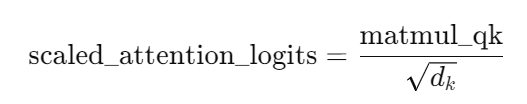



In [3]:
#computes the attention scores and output for a given set of queries, keys, and values,
# incorporating optional masking
#q: The query matrix.
#k: The key matrix.
#v: The value matrix.
#mask: An optional tensor used to mask out certain positions (future tokens).
def scaled_dot_product_attention(q, k, v, mask):
  #the dot products between queries and keys.
  # The transpose_b=True argument transposes the keys matrix
    matmul_qk = tf.matmul(q, k, transpose_b=True)
#Scale the Attention Scores
#dk is the dimensionality of the keys or queries).
#It is cast to a floating-point number.
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # check the equation
    #raw attention scores are scaled by dividing by the square root of dk.
    #This scaling helps to stabilize gradients during training
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
      #If a mask is provided, it is used to modify the attention logits.
     #The mask is added to the scaled logits where masked positions are multiplied by -1e9
    #(a very large negative number).
     #This effectively sets those positions to zero after applying the softmax function,
     #making sure that the corresponding attention weights become zero.
        scaled_attention_logits += (mask * -1e9)
#Compute the Attention Weights
# converts the scaled attention logits into probabilities.
#The axis=-1 argument ensures that the softmax is applied across the last dimension,
#which corresponds to the keys.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

#computes the weighted sum of the values,
#where the weights are the attention weights obtained from the softmax operation.
#This produces the final output tensor,
# which combines information from the value matrix weighted by how relevant each key is to the query.
    output = tf.matmul(attention_weights, v)

#output= The result of applying the attention weights to the values.
#attention_weights= The attention weights matrix, which indicates how much focus each query has on each key.
    return output, attention_weights

- **Explanation**: This function computes scaled dot-product attention, which forms the core of attention mechanisms in transformers. It takes the query, key, and value matrices, scales the dot product of the query and key, applies a mask (if provided), and finally computes the attention-weighted output.

### 4. Multi-Head Attention (Truncated)

In [4]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output

- **Explanation**: The implementation for the `MultiHeadAttention` class is truncated, but it follows the transformer architecture where multiple attention heads are used to attend to different parts of the input sequence simultaneously.

### 5. Point-Wise Feed Forward Network

In [5]:
def point_wise_feed_forward_network(d_model, dff):
    return keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])

Explanation:
* This function creates a point-wise feed forward network, which is a key component in Transformer models.
* It uses two fully connected dense layers.
* The first layer has a hidden dimension of `dff` and applies the `ReLU` activation function to introduce non-linearity.
* The second layer projects the output back to the original dimensionality `d_model`, without any activation, making it a linear transformation.
* This kind of network is applied independently to each position in the sequence, which makes it "point-wise."


### 6. Decoder Layer

In [6]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask):
        attn1 = self.mha1(x, x, x, mask)
        attn1 = self.dropout1(attn1, training=True)
        out1 = self.layernorm1(x + attn1)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=True)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

- **Explanation**:
    - **Initialization (`__init__`)**:
        - The `DecoderLayer` is a core building block of the Transformer decoder. It consists of two main components:
            1. Multi-Head Attention (`mha1`): This layer performs self-attention on the input sequence `x`, allowing the decoder to weigh the importance of different tokens in the sequence.
            2. Feed-Forward Network (`ffn`): After attention is applied, the data passes through a point-wise feed-forward network that consists of two dense layers.
        - Layer Normalization is applied twice—before and after the feed-forward network—helping stabilize the network's training.
        - Dropout is used to prevent overfitting by randomly deactivating some neurons during training.

    - **Forward Pass (`call`)**:
        - **Step 1**: Multi-head attention is applied to the input `x`, and the result is stored in `attn1`. Dropout is applied to regularize the attention output.
        - **Step 2**: The result from the attention layer (`attn1`) is added back to the input `x` (residual connection) and normalized using `layernorm1`. This produces `out1`.
        - **Step 3**: The `out1` result is passed through the feed-forward network (`ffn_output`), and dropout is applied again for regularization.
        - **Step 4**: The output of the feed-forward network is added back to `out1` (residual connection) and normalized again via `layernorm2`, producing the final output (`out2`).
    
    - **Residual Connections**: The addition of the input (`x`) to the output of the attention and feed-forward networks is a crucial part of the Transformer architecture. It ensures that the model retains information from earlier layers.

### 7. Decoder Block

In [7]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_positional_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_positional_encoding)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=True)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, mask)

        return x

- **Explanation**:
    - **Initialization (`__init__`)**:
        - The `Decoder` class represents the entire decoder module in the Transformer model, consisting of multiple `DecoderLayer` instances stacked together.
        - **Attributes**:
            - `d_model`: The dimensionality of the embedding space.
            - `num_layers`: The number of stacked decoder layers.
            - **Embedding Layer**: The target sequence is first passed through an embedding layer that converts tokens to dense vectors of dimension `d_model`.
            - **Positional Encoding**: Since the Transformer model does not have recurrence, positional encoding is applied to provide information about the order of the sequence.
            - **Decoder Layers**: Multiple `DecoderLayer` instances (as defined earlier) are created and stored in the list `dec_layers`.
            - **Dropout**: Dropout is applied after the embedding to regularize the decoder and prevent overfitting.

    - **Forward Pass (`call`)**:
        - **Input Processing**:
            - The input sequence `x` is passed through the embedding layer, which converts tokens into dense vectors.
            - The embeddings are then scaled by the square root of the model's dimension (`d_model`) to normalize the variance in the output.
            - Positional encoding is applied to give each position in the sequence a unique representation.
            - Dropout is applied to the positional encoding output.
        
        - **Decoder Layers**: The input sequence is passed sequentially through each of the decoder layers, applying self-attention and feed-forward transformations in each layer.

    - **Final Output**:
        - The final output of the `Decoder` is a tensor with the shape `(batch_size, target_seq_len, d_model)`, where each token in the target sequence is now represented in the `d_model`-dimensional space, ready to be used for further processing (such as generating predictions).

### 8. Build the Model

In [8]:
def create_look_ahead_mask(seq_len):
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask

class TransformerDecoderModel(keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_positional_encoding, rate=0.1):
        super(TransformerDecoderModel, self).__init__()

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, max_positional_encoding, rate)
        self.final_layer = layers.Dense(target_vocab_size)

    def call(self, tar):
        seq_len = tf.shape(tar)[1]
        look_ahead_mask = create_look_ahead_mask(seq_len)

        dec_output = self.decoder(tar, look_ahead_mask)
        final_output = self.final_layer(dec_output)

        return final_output


- **Explanation**:
    - **Look-Ahead Mask (`create_look_ahead_mask`)**:
        - The function `create_look_ahead_mask` creates a mask to prevent the decoder from attending to future tokens in the sequence during training.
        - The mask is created using TensorFlow's `band_part` function, which generates a lower triangular matrix filled with ones below the diagonal and zeros elsewhere. The diagonal and lower portion are kept, while the upper portion is masked.
        - This is essential for autoregressive tasks like language generation, where the model should not see future tokens.

    - **TransformerDecoderModel**:
        - **Initialization (`__init__`)**:
            - This class defines a Transformer decoder model, where the decoder is followed by a final dense layer for generating predictions.
            - **Attributes**:
                - `decoder`: This is an instance of the `Decoder` class, which consists of multiple layers of attention and feed-forward operations.
                - `final_layer`: A dense layer that maps the output of the decoder to the target vocabulary size. This layer is responsible for producing the logits used for token predictions.

    - **Forward Pass (`call`)**:
        - **Input Processing**:
            - The `call` method takes in the target sequence `tar` and computes the sequence length.
            - The look-ahead mask is created using the `create_look_ahead_mask` function, which ensures that during training, the model cannot look ahead to future positions in the target sequence.
        
        - **Decoder**:
            - The target sequence, along with the look-ahead mask, is passed to the `Decoder`, which applies the necessary layers (self-attention, feed-forward networks, etc.) to produce the decoder output.
        
        - **Final Output**:
            - The output of the decoder is passed through the `final_layer`, which converts the output into a tensor with dimensions corresponding to the target vocabulary size. This is the prediction layer where the model generates probabilities for each token in the vocabulary.
            - The final output is a tensor of shape `(batch_size, target_seq_len, target_vocab_size)` that contains the logits for the vocabulary for each token in the sequence.

### 9. Training the Model

In [9]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
target_vocab_size = 8000
max_positional_encoding = 10000

decoder_model = TransformerDecoderModel(num_layers, d_model, num_heads, dff, target_vocab_size, max_positional_encoding)

decoder_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [12]:
text_file_path = 'shakespeare.txt'
with open(text_file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([text_data])

sequences = tokenizer.texts_to_sequences([text_data])[0]

sequence_length = 50
input_sequences = []
target_sequences = []

for i in range(0, len(sequences) - sequence_length):
    input_sequences.append(sequences[i:i + sequence_length])
    target_sequences.append(sequences[i + 1:i + sequence_length + 1])

input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

vocab_size = len(tokenizer.word_index) + 1

In [14]:
batch_size = 64
buffer_size = 10000

dataset = tf.data.Dataset.from_tensor_slices((input_sequences, target_sequences))
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [15]:
target_vocab_size = vocab_size

decoder_model = TransformerDecoderModel(
    num_layers=4, d_model=128, num_heads=8, dff=512,
    target_vocab_size=target_vocab_size,
    max_positional_encoding=sequence_length
)

decoder_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [16]:
epochs = 1
decoder_model.fit(dataset, epochs=epochs)

1472/1472 ━━━━━━━━━━━━━━━━━━━━ 1194s 799ms/step - loss: 2.1332


### 10. Generating Text with the Model

In [17]:
def generate_text(model, tokenizer, seed_text, num_generate=100):
    input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
    input_sequence = np.array(input_sequence).reshape(1, -1)

    generated_text = seed_text

    for _ in range(num_generate):
        predictions = model(input_sequence)
        predictions = predictions[:, -1, :]  # Get the last predicted token
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        predicted_char = tokenizer.index_word[predicted_id]
        generated_text += predicted_char

        input_sequence = np.append(input_sequence[0], predicted_id)[-sequence_length:].reshape(1, -1)

    return generated_text

seed_text = "To be, or not to be, that is"
generated = generate_text(decoder_model, tokenizer, seed_text)
print(generated)

To be, or not to be, that is he in true my gotle,
but love is shere priting of true,
buth with holy new,  maystand it which look
